# Final Project - Analysis of Census Income Data

## Dane Jordan

__Note: The relative links in the "Contents" section below do not work in the GitHub interface when viewing the ipynb. Should you wish to use the links you will need to download the ipynb.__

## Contents

- [Introduction](#Introduction)
- [Background/Related Work](#Background/Related-Work)
- [Methods](#Methods)
  - [Getting the census income data](#Getting-the-census-income-data)
  - [Exploratory data analysis - EDA](#Exploratory-data-analysis---EDA)
  - [Data cleaning](#Data-cleaning)
  - [Deal with missing values and encode categorical features](#Deal-with-missing-values-and-encode-categorical-features)
  - [Modeling](#Modeling)
    - [Split DataFrame into training and testing](#Split-DataFrame-into-training-and-testing)
    - [Split into features/response, training/validation, and standardize/scale data](#Split-into-features/response,-training/validation,-and-standardize/scale-data)
- [Findings](#Findings)
  - [Visualize Pearson correlation confusion matrix among features](#Visualize-Pearson-correlation-confusion-matrix-among-features)
  - [Fit logistic regression model with cross-validation and calculate accuracy](#Fit-logistic-regression-model-with-cross-validation-and-calculate-accuracy)
  - [Visualize the coefficients](#Visualize-the-coefficients)
- [Discussion/Implications](#Discussion/Implications)
- [Conclusion](#Conclusion)
- [References](#References)

## Introduction
[[back to Contents](#Contents)]

words

## Background/Related Work
[[back to Contents](#Contents)]

words

## Methods
[[back to Contents](#Contents)]

Import necessary libraries that will be used

In [26]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn import metrics
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler

%matplotlib inline

Turn off unnecessary warnings. When reassigning columns while changing categorical variables into numerical equivalents or boolean alternatives, pandas throws a warning for a `SettingWithCopyWarning`. This is unnecessary for our purposes and as such it has been turned off to not add confusion during this analysis.

In [27]:
# turn off warning for chained assignment (unnecessary for operation)
pd.options.mode.chained_assignment = None

Define functions that will be used throughout the analysis. To save ourselves from repetitive code use, we have implemented some functions. They are as follows:
- `binarize_cat_vars` - encodes the categorical features as new features in a boolean format (extends the feature space significantly)
- `corr_heatmap` - visualize Pearson correlation heatmap for a DataFrame
- `data_prep` - separates the features and response, splits the data into a training and testing set, and standardizes/scales the feature data appropriately
- `encode_cat_vars` - arbitrarily encodes the categorical features as numeric
- `model_logistic` - trains a LogisticRegressionCV() model and returns accuracy scores against a validation set and a test set
- `visualize_coefs` - plots a bar graph of the fitted model coefficients (sorted)

In [68]:
def binarize_cat_vars(df):
    
    '''
    encodes the categorical features as new features in a boolean format (extends the feature space significantly)
    :param df: DataFrame to be encoded
    '''
    
    # assing the label binarizer and label encoder
    lb = LabelBinarizer()
    le = LabelEncoder()
    
    # create list of labels
    label_list = ['type_employer',
                  'marital',
                  'occupation',
                  'relationship',
                  'race',
                  'country']
    
    binary_label_list = ['sex',
                         'income']
    
    # change the categorical variables to features and associated binary indicator
    for i in df[label_list]:
        k = 0
        for j in sorted(df[i].unique()):
            df[str(i + '_' + j)] = lb.fit_transform(df[i])[:, k]
            k += 1
    
    # change the categorical variables that are already binary to numerical
    for i in binary_label_list:
        df[i] = le.fit_transform(df[i])
    
    # drop columns that have been binarized
    df = df.drop(label_list, axis=1)
    
    # return new df with categorical variables encoded as features
    return df


def corr_heatmap(df, title_prefix='', figsize=(12, 12), annot=True, cbar=False, threshold=0, label_size=25, tick_size=20):
    
    '''
    visualize pearson correlation heatmap for a DataFrame
    :param df: DataFrame
    :param annot: boolean
    '''
    
    df = np.round(df.corr(), decimals=2) + 0
    fig, ax = plt.subplots(figsize=figsize)
    sns.heatmap(df[(df >= threshold) | (df <= -threshold)], center=0, annot=annot, fmt='.2g', annot_kws={'size': 16}, square=True, cbar=cbar)
    sns.plt.title(str(title_prefix + 'Pearson Correlations'), fontsize=30)
    sns.plt.xlabel('Features', fontsize=label_size)
    sns.plt.xticks(fontsize=tick_size, rotation='vertical')
    sns.plt.ylabel('Features', fontsize=label_size)
    sns.plt.yticks(fontsize=tick_size, rotation='horizontal')
    plt.tight_layout()


def data_prep(df, train_size=0.67):
    
    '''
    separates the features and response, splits the data into a training and testing set,
    and standardizes/scales the feature data appropriately
    :param df: DataFrame containing feature/response data to be prepared
    :param train_size: percentage of data split into the training set
    '''

    # separate the features from the response
    df_features = df.drop(['income'], axis=1)
    df_response = df['income']

    # split the data into a training and testing set
    x_train, x_test, y_train, y_test = train_test_split(df_features,
                                                        df_response,
                                                        train_size=train_size,
                                                        random_state=6,
                                                        stratify=df_response)

    # assign the standard scaler
    scaler = StandardScaler()

    # standardize and scale the data (not including the response variable, income)
    x_train = scaler.fit_transform(x_train)
    x_test = scaler.transform(x_test)
    
    # return training and testing sets with features and response separated
    return x_train, x_test, y_train, y_test


def encode_cat_vars(df):

    '''
    arbitrarily encodes the categorical features as numeric
    :param df: DataFrame to be encoded
    '''
    
    # assign the label encoder
    le = LabelEncoder()
    
    # create list of labels
    label_list = ['type_employer',
                  'marital',
                  'occupation',
                  'relationship',
                  'race',
                  'sex',
                  'country',
                  'income']

    # change the categorical variables to an associated numerical label for ML
    for i in label_list:
        try:
            df[i] = le.fit_transform(df[i])
        except KeyError:
            pass

    # return new df with categorical variables encoded
    return df


def get_counts(feature):
    
    '''
    gets counts of the categories contained within a feature
    :param feature: the selected feature to get counts for
    '''
    
    return pd.DataFrame(df.groupby([feature])['age'].count()).reset_index().rename_axis({'age': 'count'}, axis=1)


def model_logistic(x_train, x_valid, x_test, y_train, y_valid, y_test):
    
    '''
    trains a LogisticRegressionCV() model and returns accuracy scores against a validation and test set
    :param x_train: DataFrame
    :param x_valid: DataFrame
    :param x_test: DataFrame
    :param y_train: DataFrame
    :param y_valid: DataFrame
    :param y_test: DataFrame
    '''
    
    clf_logCV = LogisticRegressionCV()
    clf_logCV.fit(x_train, y_train)
    
    y_predict_valid = clf_logCV.predict(x_valid)
    print('Validation Accuracy: %.2f' % (metrics.accuracy_score(y_predict_valid, y_valid)*100) + '%')
    
    y_predict_test = clf_logCV.predict(x_test)
    print('Test Accuracy: %.2f' % (metrics.accuracy_score(y_predict_test, y_test)*100) + '%')
    
    return clf_logCV


def visualize_coefs(model, df, title_prefix='', label_size=25, tick_size=25):
    
    '''
    plots a bar graph of the fitted model coefficients (sorted)
    :param model: fitted ML model
    :param df: DataFrame associated with model
    '''
    
    ax = pd.DataFrame({'coef': model.coef_[0], 'variable': df.columns[:-1]})
    ax.sort_values('coef').plot(x='variable', y='coef', kind='bar', figsize=(16, 12), fontsize=20, legend=False)
    plt.title(str(title_prefix + 'Logistic Regression Coefficients'), fontsize=30)
    plt.xlabel('Features', fontsize=label_size)
    plt.xticks(fontsize=tick_size)
    plt.ylabel('Coefficient Values', fontsize=label_size)
    plt.tight_layout()

### Getting the census income data

The dataset, "[US Adult Income](https://www.kaggle.com/johnolafenwa/us-census-data)," was obtained from [Kaggle](https://www.kaggle.com) on 11/09/2017. It was downloaded as a zipped folder and the `adult-training.csv` and `adult-test.csv` files were extracted.

- [CC0 1.0](https://creativecommons.org/publicdomain/zero/1.0/)

A header is manually specified and the dataset is read into two pandas DataFrames below; one for the training set and one for the test set. The two are then combined. When reading in the data, all question marks are replaced with null values (missing data). We print the shape of the datasets to ensure that they are combined correctly and the dimensions are what we expect them to be.

In [29]:
# create header row as neither csv has a header
header = ['age',
          'type_employer',
          'fnlwgt',
          'education',
          'education_num',
          'marital',
          'occupation',
          'relationship',
          'race',
          'sex',
          'capital_gain',
          'capital_loss',
          'hr_per_week',
          'country',
          'income']

# read in the data from the two csv files
df_train = pd.read_csv('../data_raw/adult-training.csv', names=header, na_values=[' ?'])
df_test = pd.read_csv('../data_raw/adult-test.csv', names=header, skiprows=1, na_values=[' ?'])

# print the shape of the data
print('Shape of adult-training csv: ' + str(df_train.shape))
print('Shape of adult-test.csv: ' + str( df_test.shape))

# combine the two DataFrames into one dataset
df = df_train.append(df_test)

# print the shape of the full dataset
print('Shape of combined csv data: ' + str(df.shape))

Shape of adult-training csv: (32561, 15)
Shape of adult-test.csv: (16281, 15)
Shape of combined csv data: (48842, 15)


### Exploratory data analysis - EDA

At a high level we explore the data. We beging by looking for categorical variables, numerical variables, and determine how many possible values there are for each feature.

In [58]:
# create DataFrame for nice presentation
summary = pd.DataFrame(columns=['feature', 'unique_count', 'dtype'])

# loop through features and append summary statistics to the DataFrame
for i in df.columns:
    summary = summary.append(pd.DataFrame({'feature': [i],
                                           'unique_count': [str(len(df[i].unique()))],
                                           'dtype': [str(df[i].dtype)]}))

# print DataFrame
summary[['feature', 'dtype', 'unique_count']].reset_index(drop=True)

,feature,dtype,unique_count
0,age,int64,74
1,type_employer,object,9
2,fnlwgt,int64,28523
3,education,object,16
4,education_num,int64,16
5,marital,object,7
6,occupation,object,15
7,relationship,object,6
8,race,object,5
9,sex,object,2


It is interesting to see that the features `capital_gain` and `capital_loss` have such low unique counts. We would typically expect these to be quite high as they are not categorical in nature. The features `age`, `education_num` and `hr_per_week` are expected to be more categorical the lifespan of human rarely exceeds 100, the number of hours worked per week can only be a maximum of 168 (and even this number is impractical), and the `education_num` feature is simply a numerical representation of the `education` feature. The `fnlwgt` feature will not be used for the purposes of this analysis and will be removed during the [data cleaning](#Data-cleaning) process. Before moving forward we will look at the two education features to see if they confirm our assumption

In [72]:
pd.DataFrame(df.groupby(['education_num', 'education'])['age'].count()).reset_index().rename_axis({'age': 'count'}, axis=1)

,education_num,education,count
0,1,Preschool,83
1,2,1st-4th,247
2,3,5th-6th,509
3,4,7th-8th,955
4,5,9th,756
5,6,10th,1389
6,7,11th,1812
7,8,12th,657
8,9,HS-grad,15784
9,10,Some-college,10878


Yes, it appears that our assumption is confirmed. Next we will look at some high-level summary statistics for the numerical values discussed above to see if we can gain any more insight into the data. Any 'zero' values are replaced by NaNs so that they are not counted. If any of the numerical features have a value of zero, this indicates that data does not exist for this individual. This does not necessarily mean data is 'missing,' but simply that it does not exist.

In [31]:
# high-level summary statistics for numerical values
df.replace(0, np.NaN).describe()

,age,fnlwgt,education_num,capital_gain,capital_loss,hr_per_week
count,48842.000000,4.884200e+04,48842.000000,4035.000000,2282.000000,48842.000000
mean,38.643585,1.896641e+05,10.078089,13061.665675,1872.825592,40.422382
std,13.710510,1.056040e+05,2.570973,22711.237412,364.048529,12.391444
min,17.000000,1.228500e+04,1.000000,114.000000,155.000000,1.000000
25%,28.000000,1.175505e+05,9.000000,3411.000000,1672.000000,40.000000
50%,37.000000,1.781445e+05,10.000000,7298.000000,1887.000000,40.000000
75%,48.000000,2.376420e+05,12.000000,13550.000000,1977.000000,45.000000
max,90.000000,1.490400e+06,16.000000,99999.000000,4356.000000,99.000000


It appears as if the summary above has answered the interesting point made earlier regarding the `capital_gain` and `capital_loss` features. While the other numerical features all have counts of 48,842 (meaning there exists a data point for every row, the `capital_gain` and `capital_loss` features have very few data points. This could likely cause some skew or bias when determining which features correlate with income.

Going forward we will take a more in-depth look at each of the categorical features and see each of the possible categories contained within each feature as well as the number of occurrences of those categories. This could potentially provide insight into any bias that may exist in the data.

__As bar graphs:__

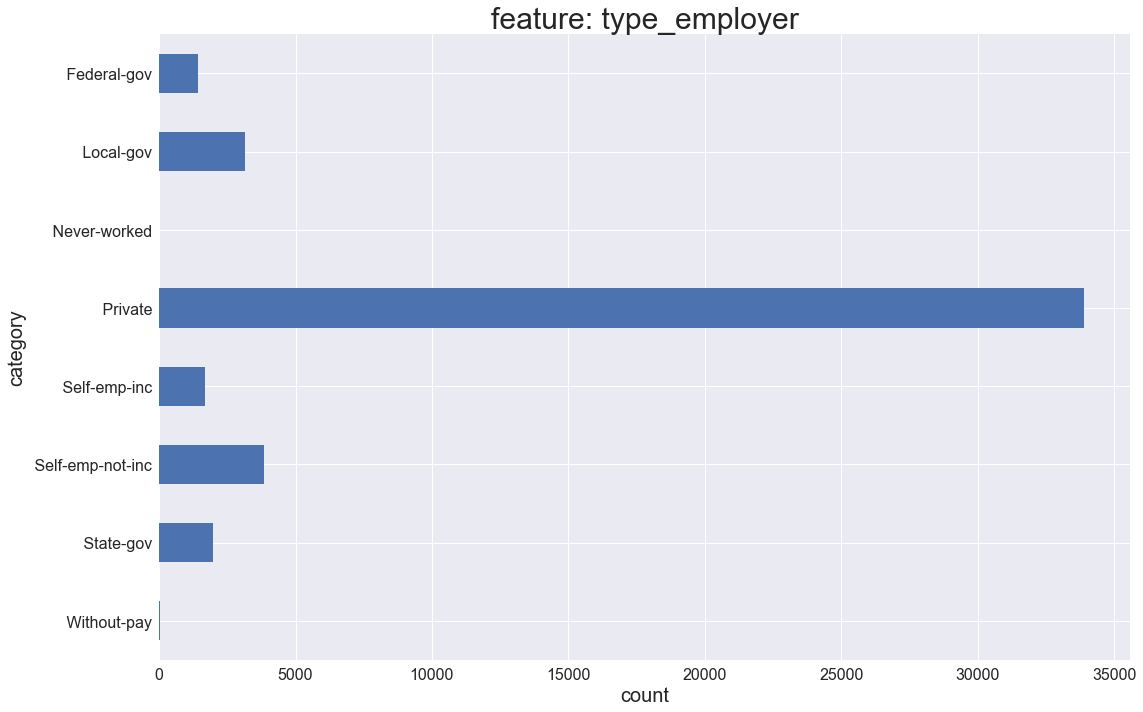

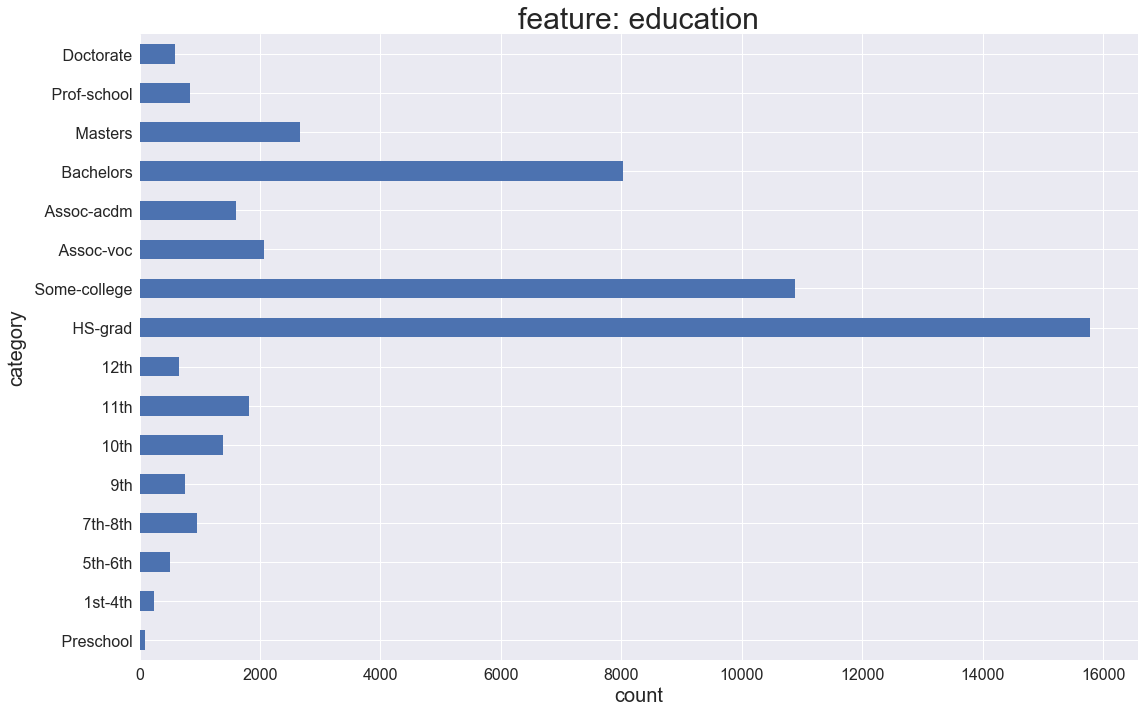

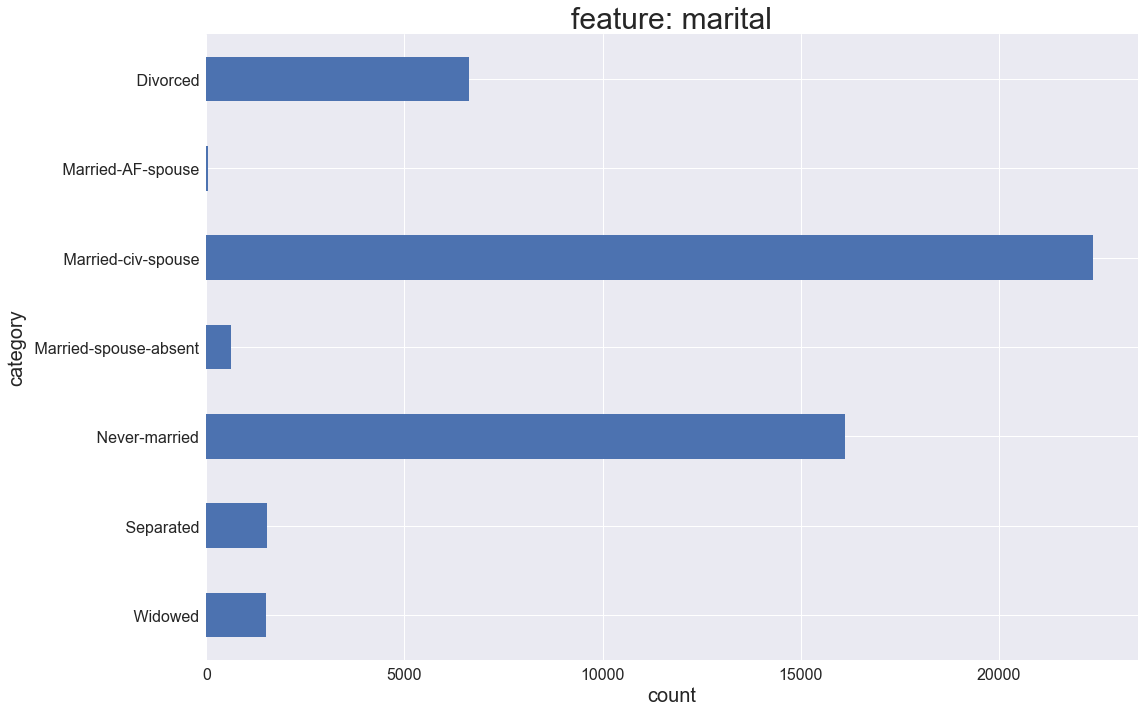

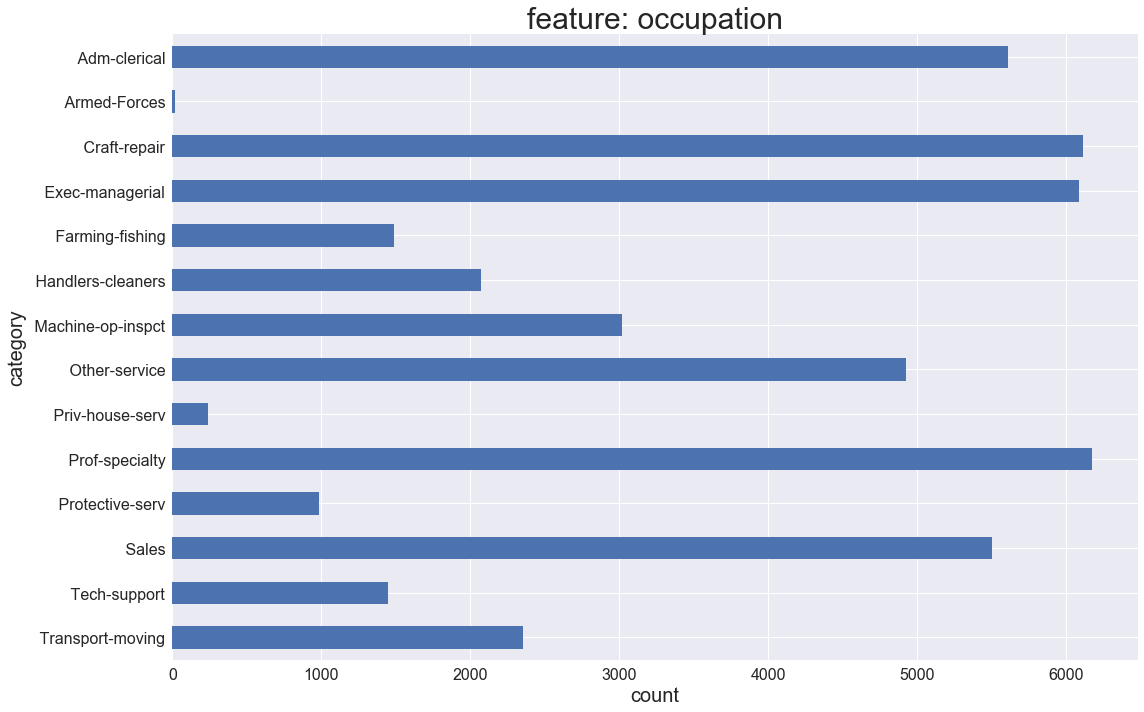

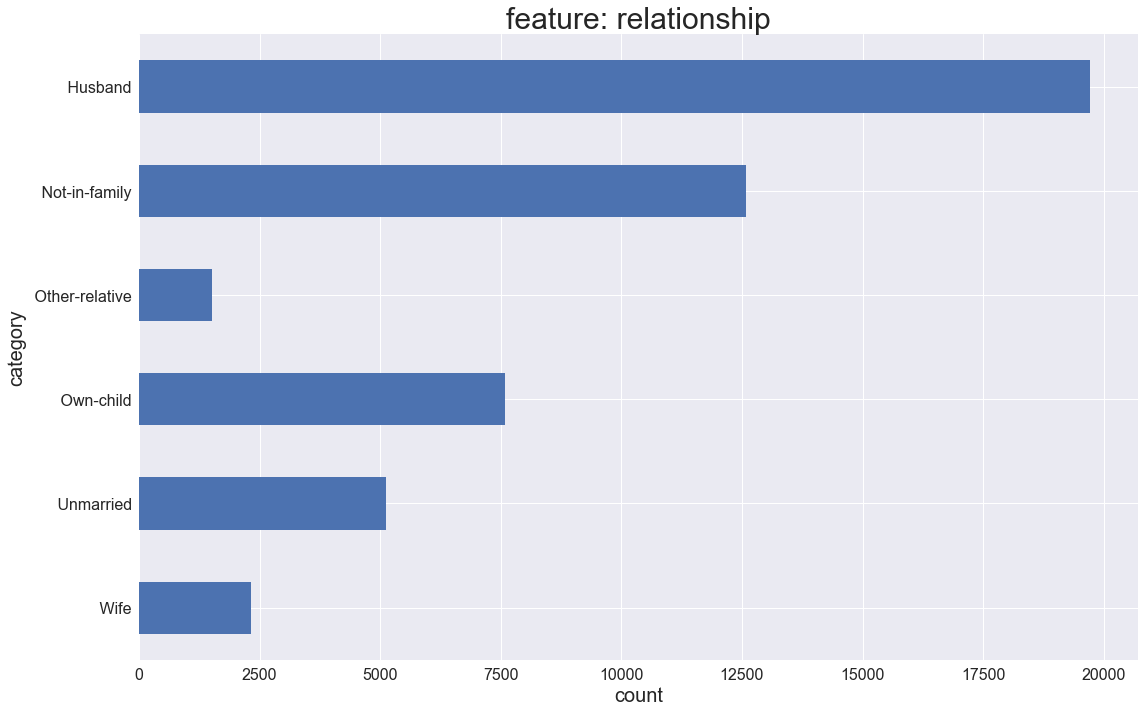

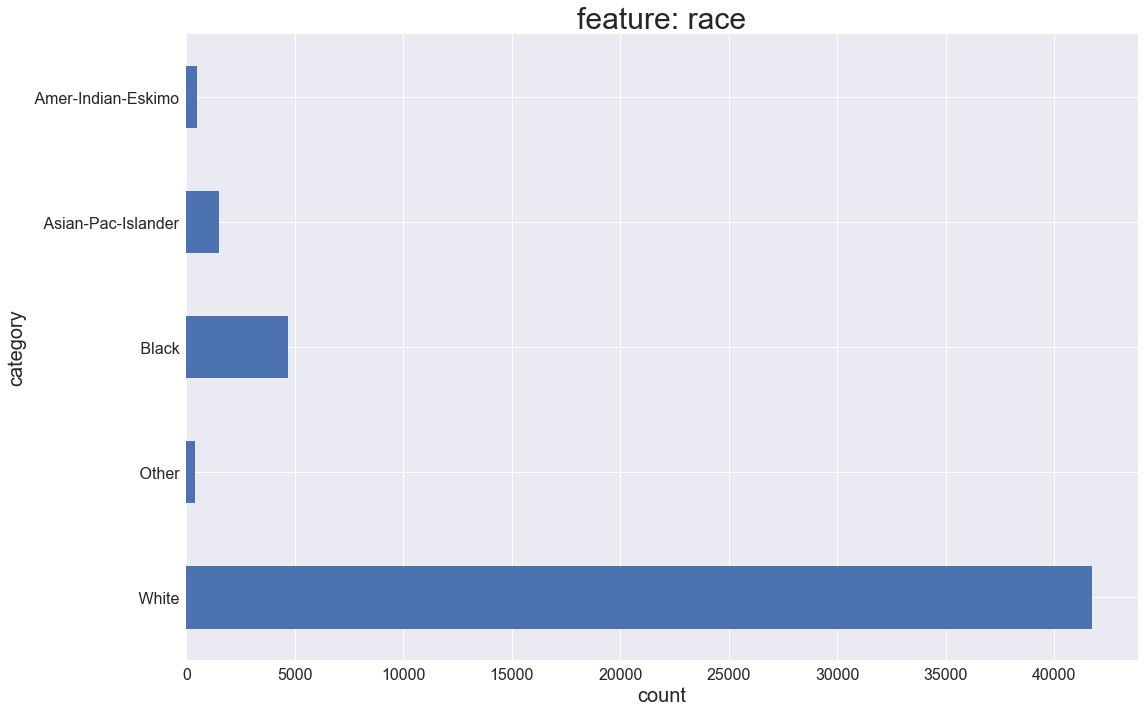

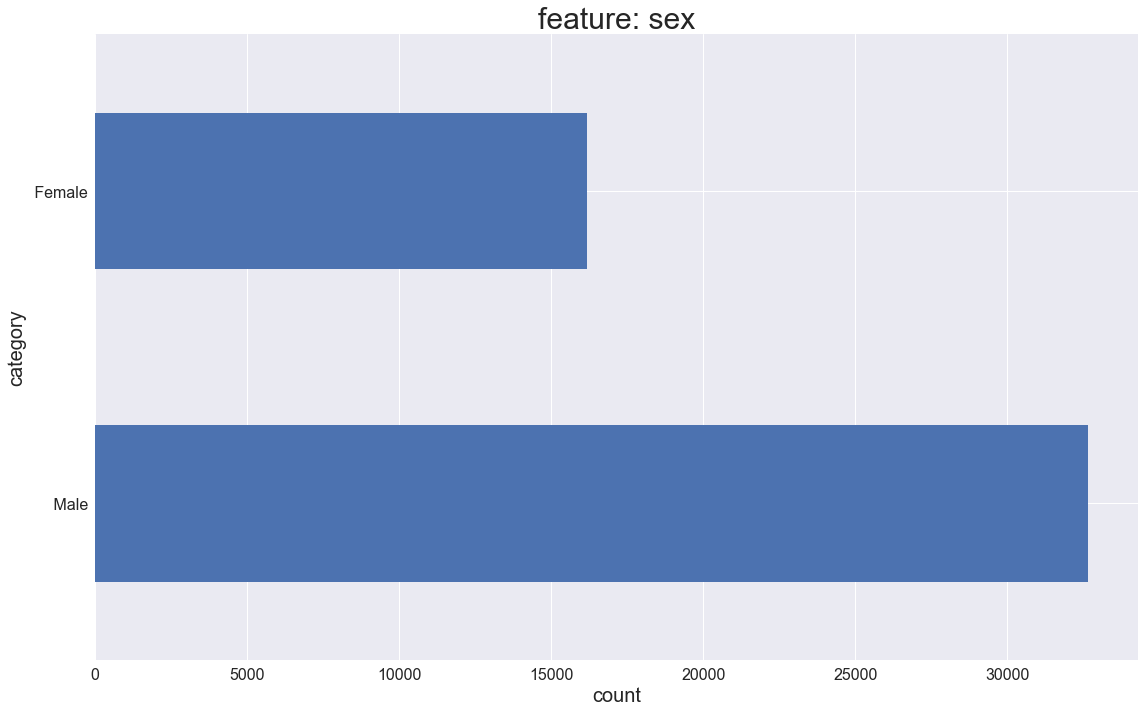

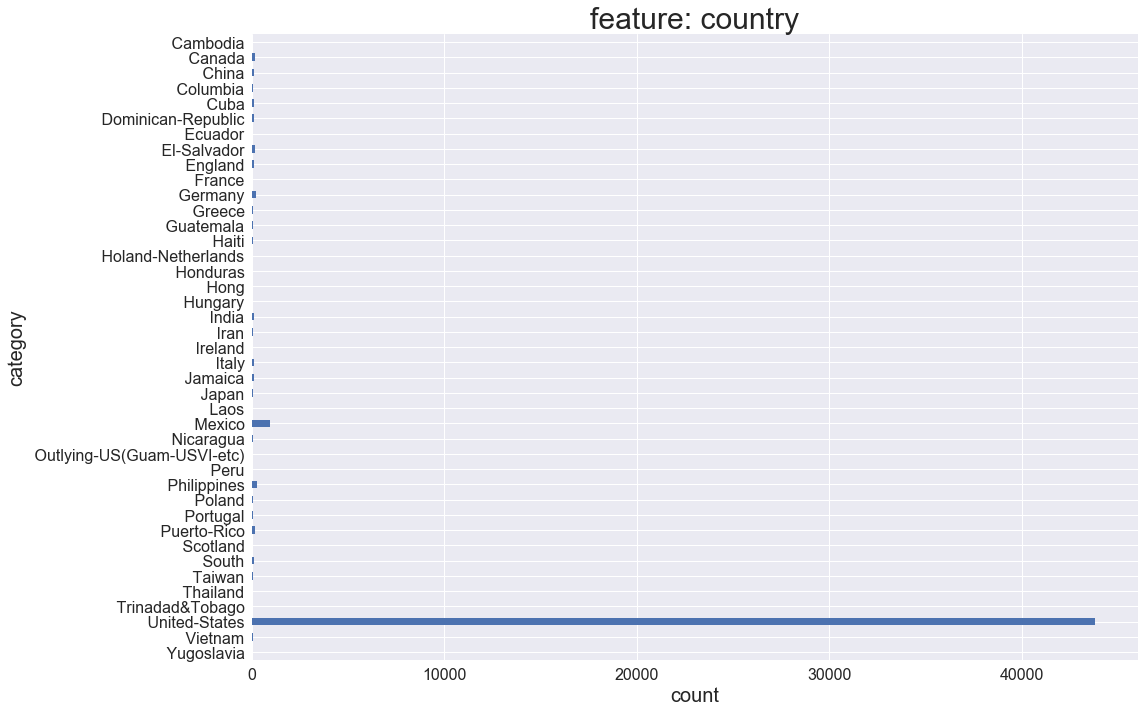

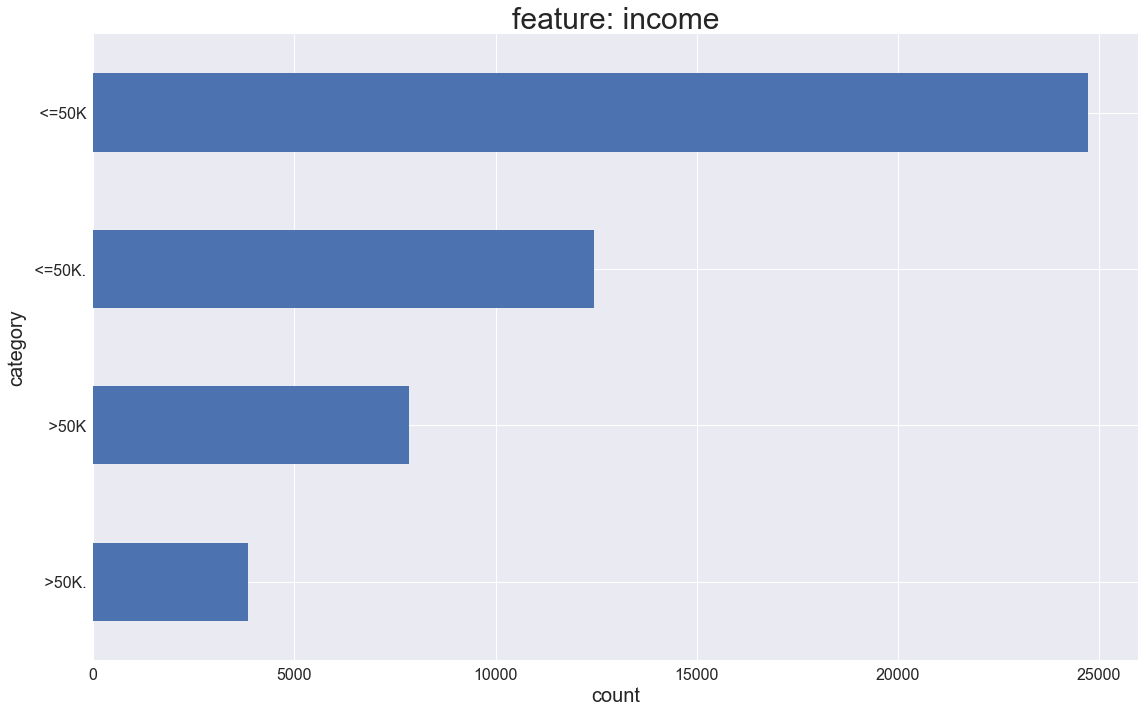

In [192]:
# define the categorical features as a list to loop through visualizing
cat_features = ['type_employer', 'education', 'marital', 'occupation', 'relationship', 'race', 'sex', 'country', 'income']

# loop through the features and visualize bar graphs
for i in cat_features:
    
    # special case for education to order it according to the feature education_num
    if i == 'education':
        temp = pd.DataFrame(df.groupby(['education_num', 'education'])['age'].count()).reset_index().rename_axis({'age': 'count'}, axis=1)
        ax = temp.iloc[:, 1:3].plot.barh(x=temp.iloc[:, 1], figsize=(16,10), legend=False)
    
    # all other features aside from education
    else:
        temp = get_counts(i).sort_values(i, ascending=False)
        ax = temp.plot.barh(x=temp.iloc[:, 0], figsize=(16,10), legend=False)
        
    # plot parameters (make it look readable and nice)
    plt.title(str('feature: ' + i), fontsize=30)
    plt.xlabel('count', fontsize=20)
    plt.xticks(fontsize=16)
    plt.ylabel('category', fontsize=20)
    plt.yticks(fontsize=16)
    plt.tight_layout()
    plt.savefig(str('../analysis/eda_' + i + '.png'))

__As tables:__

In [78]:
get_counts('type_employer')

,type_employer,count
0,Federal-gov,1432
1,Local-gov,3136
2,Never-worked,10
3,Private,33906
4,Self-emp-inc,1695
5,Self-emp-not-inc,3862
6,State-gov,1981
7,Without-pay,21


In [79]:
get_counts('education')

,education,count
0,10th,1389
1,11th,1812
2,12th,657
3,1st-4th,247
4,5th-6th,509
5,7th-8th,955
6,9th,756
7,Assoc-acdm,1601
8,Assoc-voc,2061
9,Bachelors,8025


In [80]:
get_counts('marital')

,marital,count
0,Divorced,6633
1,Married-AF-spouse,37
2,Married-civ-spouse,22379
3,Married-spouse-absent,628
4,Never-married,16117
5,Separated,1530
6,Widowed,1518


In [81]:
get_counts('occupation')

,occupation,count
0,Adm-clerical,5611
1,Armed-Forces,15
2,Craft-repair,6112
3,Exec-managerial,6086
4,Farming-fishing,1490
5,Handlers-cleaners,2072
6,Machine-op-inspct,3022
7,Other-service,4923
8,Priv-house-serv,242
9,Prof-specialty,6172


In [82]:
get_counts('relationship')

,relationship,count
0,Husband,19716
1,Not-in-family,12583
2,Other-relative,1506
3,Own-child,7581
4,Unmarried,5125
5,Wife,2331


In [83]:
get_counts('race')

,race,count
0,Amer-Indian-Eskimo,470
1,Asian-Pac-Islander,1519
2,Black,4685
3,Other,406
4,White,41762


In [84]:
get_counts('sex')

,sex,count
0,Female,16192
1,Male,32650


In [85]:
get_counts('country')

,country,count
0,Cambodia,28
1,Canada,182
2,China,122
3,Columbia,85
4,Cuba,138
5,Dominican-Republic,103
6,Ecuador,45
7,El-Salvador,155
8,England,127
9,France,38


In [86]:
get_counts('income')

,income,count
0,<=50K,24720
1,<=50K.,12435
2,>50K,7841
3,>50K.,3846


Overall, the integrity of the data itself is pretty good. It is quite clean and easy to work with. There are a few issues that we need to address before moving forward. We will go over each categorical feature to identify any issues or concerns regarding its integrity.

The first feature is `type_employer`. 

### Data cleaning

Based on the EDA above, investigate more in depth regarding the features in the dataset. Check for duplicates, missing values ("should" all be assigned already), and data that does not appear correct. For the purposes of this analysis we will not use the `fnlwgt` feature.

In [15]:
# drop 'fnlwgt'
df = df.drop('fnlwgt', axis=1)

Let's first look at how many rows contain missing data, and more specifcally which columns (if any) are represented in the missing data by a count of the number of occurrences.

In [16]:
# print missing data information
print('Rows with missing data: ' + str(df[df.isnull().any(axis=1)].shape[0]))
print('Rows without missing data: ' + str(df[df.notnull().all(axis=1)].shape[0]))
pd.DataFrame(df.isnull().sum(axis=0), columns=['missing_count'])

Rows with missing data: 3620
Rows without missing data: 45222


,missing_count
age,0
type_employer,2799
education,0
education_num,0
marital,0
occupation,2809
relationship,0
race,0
sex,0
capital_gain,0


For the purposes of using the function `LabelEncoder()` we will fill all of the missing values with a string (str) as the `LabelEncoder()` function is unable to read actual `NaN` values.

In [17]:
# fill na values with string
df = df.fillna('NaN')

#### Relationship between education and education_num
Due to the direct relationship (1:1), we do not need to include both of these variables. One will be discarded later on.

In [18]:
# pivot to see relationship between 'education' and 'education_num' variables
pd.pivot_table(df[['education', 'education_num']], index=['education']).sort_values('education_num')

,education_num
education,
Preschool,1
1st-4th,2
5th-6th,3
7th-8th,4
9th,5
10th,6
11th,7
12th,8
HS-grad,9


Drop `education` feature as mentioned above

In [19]:
# drop duplicate dolumn
df = df.drop('education', axis=1)

#### Summary of data's integrity from a technical standpoint

__age__:  
Self-explanatory; data okay.

__type_employer__:  
Self-explanatory; missing data. Possible solutions - remove rows associated with missing values, or remove feature from data.

__education/education_num__:  
What is the difference between `Assoc-voc` and `Assoc-acdm`?

__marital__:  
What is the difference between `Married-AF-spouse` and `Married-civ-spouse`? It turns out that one refers to armed forces and the other refers to civilian.

__occupation__:  
This list includes a VERY broad range of occupations and does not provide much detail. The list itself is self-explanatory. There is missing data with the possible solutions - remove rows associated with missing values, or remove feature from data.

__relationship__:  
Not quite sure what this variable represents.

__race__:  
Self-explanatory; data okay. This variable is EXTREMELY limiting and does not recognize several different races.

__sex__:  
Self-explanatory; data okay. This variable indicates sex at birth only.

__capital_gain/capital_loss__:  
Continuous numerical value. Self-explanatory; data okay.

__hr_per_week__:  
Continuous numerical value. Self-explanatory; data okay.

__country__:  
The `country` variable appears to do a poor job describing country of origin. For example, what is "South?"

__income__:  
This variable should be binary and has multiple values that mean the same thing. The "." needs to be stripped from the end of two possible occurrences in the data to make it uniform.

#### Fix encoding for `income` response variable (should be binary)

In [20]:
# fix dupicate results for 'income' variable
df['income'] = df['income'].str.replace('.', '')
df['income'].unique()

array([' <=50K', ' >50K'], dtype=object)

### Deal with missing values and encode categorical features

We have chosen four different approaches for dealing with missing values and encoding categorical features. These methods represent the progression of thought, beginning with method 1 and iterating until we achieved a more optimal and sound technique with method 4.

1. Delete all rows associated with missing values reducing the total number of rows from 48,842 to 45,222 and naively encode categorical features.
2. Delete features associated with missing values reducing the feature space from 14 to 11 and naively encode categorical features.
3. Encode missing values as a category (not advised). This does not remove any features or rows.
4. Binarize the categorical features (expand feature space significantly).

__Note: The code to save the cleaned data has been commented out for the purposes of reproducibility.__

In [21]:
## method 1
# drop rows with missing data
df_m1 = df[((df['type_employer'] != 'NaN') &
            (df['occupation'] != 'NaN') &
            (df['country'] != 'NaN'))].reset_index(drop=True)
df_m1 = encode_cat_vars(df_m1)
# df_m1.to_csv('../data_clean/method1.csv', index=False)

## method 2
# drop features with missing data
df_m2 = df.drop(['type_employer', 'occupation', 'country'], axis=1).reset_index(drop=True)
df_m2 = encode_cat_vars(df_m2)
# df_m2.to_csv('../data_clean/method2.csv', index=False)

## method 3
# copy DataFrame to new variable and encode categorical variables
df_m3 = df.copy()
df_m3 = encode_cat_vars(df_m3)
# df_m3.to_csv('../data_clean/method3.csv', index=False)

## method 4
# copy DataFrame to new variable
df_m4 = df.copy()
df_m4 = binarize_cat_vars(df_m4)
df_m4 = df_m4.drop(['type_employer_NaN', 'occupation_NaN', 'country_NaN'], axis=1)
# df_m4.to_csv('../data_clean/method4.csv', index=False)

### Split DataFrame into training and testing

This split is done so that we do not perform any training on the true test set. We will split the training set later into a training/validation set that will be used to train and test the model(s). Once a model has been tuned it will be tested against the holdout test set we create below. Please note that a random state has been instantiated so that the results are reproducible.

In [22]:
# randomly split 25% for a test set
df_m1_test = df_m1.sample(frac=1/4, random_state=6)
df_m2_test = df_m2.sample(frac=1/4, random_state=6)
df_m3_test = df_m3.sample(frac=1/4, random_state=6)
df_m4_test = df_m4.sample(frac=1/4, random_state=6)

# keep the remaining 75% for a training set
df_m1_train = df_m1.drop(df_m1_test.index.values)
df_m2_train = df_m2.drop(df_m2_test.index.values)
df_m3_train = df_m3.drop(df_m3_test.index.values)
df_m4_train = df_m4.drop(df_m4_test.index.values)

### Split into features/response, training/validation, and standardize/scale data

Here we perform the standard train/validation split after first splitting the data between the features and response. The split is done as a 67/33 split such that the overall splits (including the step before) create a 50% train, 25% validation and 25% test set. Please note that, as above, a random state has been instantiated so that the results are reproducible.

In [23]:
# prepare the data for modeling
x_train_m1, x_valid_m1, y_train_m1, y_valid_m1 = data_prep(df_m1_train)
x_train_m2, x_valid_m2, y_train_m2, y_valid_m2 = data_prep(df_m2_train)
x_train_m3, x_valid_m3, y_train_m3, y_valid_m3 = data_prep(df_m3_train)
x_train_m4, x_valid_m4, y_train_m4, y_valid_m4 = data_prep(df_m4_train)

# standardize and scale the test set as well (no split)
x_test_m1, x_null_m1, y_test_m1, y_null_m1 = data_prep(df_m1_test)
x_test_m2, x_null_m2, y_test_m2, y_null_m2 = data_prep(df_m2_test)
x_test_m3, x_null_m3, y_test_m3, y_null_m3 = data_prep(df_m3_test)
x_test_m4, x_null_m4, y_test_m4, y_null_m4 = data_prep(df_m4_test)

# combine the splits back (just utilized the function to standardize and scale)
x_test_m1 = np.vstack((x_test_m1, x_null_m1))
y_test_m1 = np.append(y_test_m1, y_null_m1)
x_test_m2 = np.vstack((x_test_m2, x_null_m2))
y_test_m2 = np.append(y_test_m2, y_null_m2)
x_test_m3 = np.vstack((x_test_m3, x_null_m3))
y_test_m3 = np.append(y_test_m3, y_null_m3)
x_test_m4 = np.vstack((x_test_m4, x_null_m4))
y_test_m4 = np.append(y_test_m4, y_null_m4)

## Findings
[[back to Contents](#Contents)]

words

### Visualize Pearson correlation confusion matrix among features

In [ ]:
corr_heatmap(df_m1, title_prefix='Method 1: ')
plt.savefig('../analysis/m1_pearson_corr_heatmap.png')
corr_heatmap(df_m1, title_prefix='Filtered Method 1: ', threshold=0.2)
plt.savefig('../analysis/m1_pearson_corr_heatmap_filtered.png')
corr_heatmap(df_m2, title_prefix='Method 2: ')
corr_heatmap(df_m3, title_prefix='Method 3: ')
corr_heatmap(df_m4, title_prefix='Method 4: ', figsize=(16, 12), annot=False, cbar=True, tick_size=10)
plt.savefig('../analysis/m4_pearson_corr_heatmap.png')

### Fit logistic regression model with cross-validation and calculate accuracy

In [ ]:
print('Method 1:')
model1 = model_logistic(x_train_m1, x_valid_m1, x_test_m1, y_train_m1, y_valid_m1, y_test_m1)
print('\nMethod 2:')
model2 = model_logistic(x_train_m2, x_valid_m2, x_test_m2, y_train_m2, y_valid_m2, y_test_m2)
print('\nMethod 3:')
model3 = model_logistic(x_train_m3, x_valid_m3, x_test_m3, y_train_m3, y_valid_m3, y_test_m3)
print('\nMethod 4:')
model4 = model_logistic(x_train_m4, x_valid_m4, x_test_m4, y_train_m4, y_valid_m4, y_test_m4)

### Visualize the coefficients

In [ ]:
visualize_coefs(model1, df_m1, title_prefix='Model 1: ')
plt.savefig('../analysis/m1_coefficient_values_bargraph.png')
visualize_coefs(model2, df_m2, title_prefix='Model 2: ')
visualize_coefs(model3, df_m3, title_prefix='Model 3: ')
visualize_coefs(model4, df_m4, title_prefix='Model 4: ', tick_size=10)
plt.savefig('../analysis/m4_coefficient_values_bargraph.png')

## Discussion/Implications
[[back to Contents](#Contents)]

words

## Conclusion
[[back to Contents](#Contents)]

words

## References
[[back to Contents](#Contents)]

words